#ML_Project_Cryptocurrency Liquidity_Assignment

1. Load both datasets into pandas DataFrames. Data collection followed by cleaning, and preprocessing phase.

In [4]:
from google.colab import files
import pandas as pd
import io

print("Please select your dataset files (.csv)...")
uploaded = files.upload()

#Load datasets into Pandas DataFrames
df1 = None
df2 = None

if 'crypto_market_snapshot.csv' in uploaded:
    df1 = pd.read_csv(io.BytesIO(uploaded['crypto_market_snapshot.csv']))
    print("Loaded: crypto_market_snapshot.csv")
else:
    print("File crypto_market_snapshot.csv not found in upload!")

if 'crypto_market_snapshot_v2.csv' in uploaded:
    df2 = pd.read_csv(io.BytesIO(uploaded['crypto_market_snapshot_v2.csv']))
    print("Loaded: crypto_market_snapshot_v2.csv")
else:
    print("File crypto_market_snapshot_v2.csv not found in upload!")

#Verify the datasets
def verify_dataframe(df, name):
    if df is not None:
        print(f"\n{name} - Shape: {df.shape}")
        print(df.info())
        print("\nFirst 5 rows:")
        print(df.head())
    else:
        print(f"{name} was NOT loaded!")

verify_dataframe(df1, "Dataset 1 (crypto_market_snapshot)")
verify_dataframe(df2, "Dataset 2 (crypto_market_snapshot_v2)")

#Save uploaded files to Colab environment for later use. This step makes the files persistent while your Colab runtime is active
import os
for filename in uploaded.keys():
    with open(filename, 'wb') as f:
        f.write(uploaded[filename])
    print(f"File saved in Colab environment: {filename}")


Please select your dataset files (.csv)...


Saving coin_gecko_2022-03-16.csv to coin_gecko_2022-03-16.csv
Saving coin_gecko_2022-03-17.csv to coin_gecko_2022-03-17.csv
File crypto_market_snapshot.csv not found in upload!
File crypto_market_snapshot_v2.csv not found in upload!
Dataset 1 (crypto_market_snapshot) was NOT loaded!
Dataset 2 (crypto_market_snapshot_v2) was NOT loaded!
File saved in Colab environment: coin_gecko_2022-03-16.csv
File saved in Colab environment: coin_gecko_2022-03-17.csv


In [5]:
#Load uploaded CSV files
import pandas as pd
file_day_1 = "coin_gecko_2022-03-16.csv"
file_day_2 = "coin_gecko_2022-03-17.csv"

# Load and Verify both datasets
df1 = pd.read_csv(file_day_1)
df2 = pd.read_csv(file_day_2)
def verify_dataframe(df, name):
    print(f"\n{name} - Shape: {df.shape}")
    print(df.info())
    print("\nFirst 5 rows:")
    print(df.head())

verify_dataframe(df1, "Dataset 1 (16-Mar-2022)")
verify_dataframe(df2, "Dataset 2 (17-Mar-2022)")

# Check column names to confirm schema
print("\nColumns in Dataset 1:", df1.columns.tolist())
print("Columns in Dataset 2:", df2.columns.tolist())



Dataset 1 (16-Mar-2022) - Shape: (500, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   coin        500 non-null    object 
 1   symbol      500 non-null    object 
 2   price       500 non-null    float64
 3   1h          497 non-null    float64
 4   24h         497 non-null    float64
 5   7d          497 non-null    float64
 6   24h_volume  497 non-null    float64
 7   mkt_cap     500 non-null    float64
 8   date        500 non-null    object 
dtypes: float64(6), object(3)
memory usage: 35.3+ KB
None

First 5 rows:
       coin symbol         price     1h    24h     7d    24h_volume  \
0   Bitcoin    BTC  40859.460000  0.022  0.030  0.055  3.539076e+10   
1  Ethereum    ETH   2744.410000  0.024  0.034  0.065  1.974870e+10   
2    Tether   USDT      1.000000 -0.001 -0.001  0.000  5.793497e+10   
3       BNB    BNB    383.430000  0.018  0.02

**2. What the below code will do:**

**1. Merge Snapshots**

Adds a date column to distinguish the two snapshots.

Merges both datasets into one unified DataFrame.

**2. Clean Data**

Standardizes column names to lowercase and underscores.

Converts numeric fields like price, 24h_volume, and mkt_cap to float.

Fills or drops missing values as needed.

**3. Create Features**

volume_mcap_ratio using:
###Volume-to-Market Cap Ratio = (24h Volume​/Market Cap)

Higher values → more liquid market.

abs_1h_change, abs_24h_change, abs_7d_change → absolute volatility measures.

liquidity_label:

1 → Liquidity crisis (bottom 10% of coins by liquidity ratio)

0 → Normal liquidity

In [6]:
# Loding both Files and datasets
import pandas as pd
import numpy as np
file_day_1 = "coin_gecko_2022-03-16.csv"
file_day_2 = "coin_gecko_2022-03-17.csv"

df1 = pd.read_csv(file_day_1)
df2 = pd.read_csv(file_day_2)

print("Day 1 Shape:", df1.shape)
print("Day 2 Shape:", df2.shape)

#Add Date Column for combining both datasets, later into one file
df1['date'] = pd.to_datetime("2022-03-16")
df2['date'] = pd.to_datetime("2022-03-17")

df = pd.concat([df1, df2], ignore_index=True)
df.sort_values(by=['symbol', 'date'], inplace=True)
df.reset_index(drop=True, inplace=True)

print("Combined Shape:", df.shape)
print("Unique Coins:", df['symbol'].nunique())

#Standardize Column Names
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]
print("\nStandardized Columns:", df.columns.tolist())


#Convert numeric columns to proper dtype
numeric_cols = ['price', '1h', '24h', '7d', '24h_volume', 'mkt_cap']

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')


#Handle missing values
print("\nMissing values before cleaning:")
print(df.isna().sum())

# Fill NaN with 0 for price change metrics and drop rows missing essential data
df.fillna({'1h': 0, '24h': 0, '7d': 0}, inplace=True)
df.dropna(subset=['price', '24h_volume', 'mkt_cap'], inplace=True)

print("\nMissing values after cleaning:")
print(df.isna().sum())

#Create Liquidity Features in new Column
# 1. Volume-to-Market Cap Ratio
df['volume_mcap_ratio'] = df['24h_volume'] / df['mkt_cap']

# 2. Absolute percentage changes
df['abs_1h_change'] = df['1h'].abs()
df['abs_24h_change'] = df['24h'].abs()
df['abs_7d_change'] = df['7d'].abs()

# 3. Liquidity Crisis Label (bottom 10% of liquidity ratio)
threshold = df['volume_mcap_ratio'].quantile(0.1)
df['liquidity_label'] = (df['volume_mcap_ratio'] < threshold).astype(int)

#Final verification
print("\nFinal Dataset Info:")
print(df.info())
print("\nSample rows:")
print(df.head())


#Save Cleaned Dataset
df.to_csv("crypto_liquidity_cleaned.csv", index=False)
print("\nCleaned dataset saved as crypto_liquidity_cleaned.csv")


Day 1 Shape: (500, 9)
Day 2 Shape: (500, 9)
Combined Shape: (1000, 9)
Unique Coins: 503

Standardized Columns: ['coin', 'symbol', 'price', '1h', '24h', '7d', '24h_volume', 'mkt_cap', 'date']

Missing values before cleaning:
coin          0
symbol        0
price         0
1h            7
24h           7
7d            8
24h_volume    7
mkt_cap       0
date          0
dtype: int64

Missing values after cleaning:
coin          0
symbol        0
price         0
1h            0
24h           0
7d            0
24h_volume    0
mkt_cap       0
date          0
dtype: int64

Final Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 993 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   coin               993 non-null    object        
 1   symbol             993 non-null    object        
 2   price              993 non-null    float64       
 3   1h                 993 non-nu

**Save Final Dataset**

Exports the cleaned dataset to crypto_liquidity_cleaned.csv for further modeling.

In [7]:
# Download the cleaned dataset
from google.colab import files

files.download("crypto_liquidity_cleaned.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**3. EDA, feature engineering, model development, and evaluation**

In [8]:
#Understand the dataset, relationships, and liquidity behavior
#Basic exploration
import pandas as pd

df = pd.read_csv("crypto_liquidity_cleaned.csv")
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   coin               993 non-null    object 
 1   symbol             993 non-null    object 
 2   price              993 non-null    float64
 3   1h                 993 non-null    float64
 4   24h                993 non-null    float64
 5   7d                 993 non-null    float64
 6   24h_volume         993 non-null    float64
 7   mkt_cap            993 non-null    float64
 8   date               993 non-null    object 
 9   volume_mcap_ratio  993 non-null    float64
 10  abs_1h_change      993 non-null    float64
 11  abs_24h_change     993 non-null    float64
 12  abs_7d_change      993 non-null    float64
 13  liquidity_label    993 non-null    int64  
dtypes: float64(10), int64(1), object(3)
memory usage: 108.7+ KB


price          1h         24h          7d    24h_volume  \
count  9.930000e+02  993.000000  993.000000  993.000000  9.930000e+02   
mean   6.194355e+02    0.009723    0.023737    0.023535  2.893109e+08   
std    4.419811e+03    0.026934    0.059303    0.229667  2.769908e+09   
min    1.484000e-09   -0.704000   -0.646000   -0.558000  0.000000e+00   
25%    1.944270e-01    0.001000    0.001000   -0.041000  1.766976e+06   
50%    1.100000e+00    0.006000    0.016000    0.000000  8.343005e+06   
75%    7.150000e+00    0.019000    0.035000    0.037000  4.003652e+07   
max    4.121727e+04    0.095000    0.577000    4.608000  5.793497e+10   

            mkt_cap  volume_mcap_ratio  abs_1h_change  abs_24h_change  \
count  9.930000e+02         993.000000     993.000000      993.000000   
mean   3.780941e+09           0.103743       0.013048        0.034553   
std    3.817057e+10           0.366932       0.025488        0.053719   
min    6.577043e+07           0.000000       0.000000        0.000000   
25%    1.158653e+08           0.008774       0.002000        0.008000   
50%    2.135646e+08           0.033798       0.007000        0.021000   
75%    6.025829e+08           0.088332       0.020000        0.040000   
max    7.760774e+11           5.948545       0.704000        0.646000   

       abs_7d_change  liquidity_label  
count     993.000000       993.000000  
mean        0.082924         0.100705  
std         0.215448         0.301089  
min         0.000000         0.000000  
25%         0.014000         0.000000  
50%         0.038000         0.000000  
75%         0.081000         0.000000  
max         4.608000         1.000000

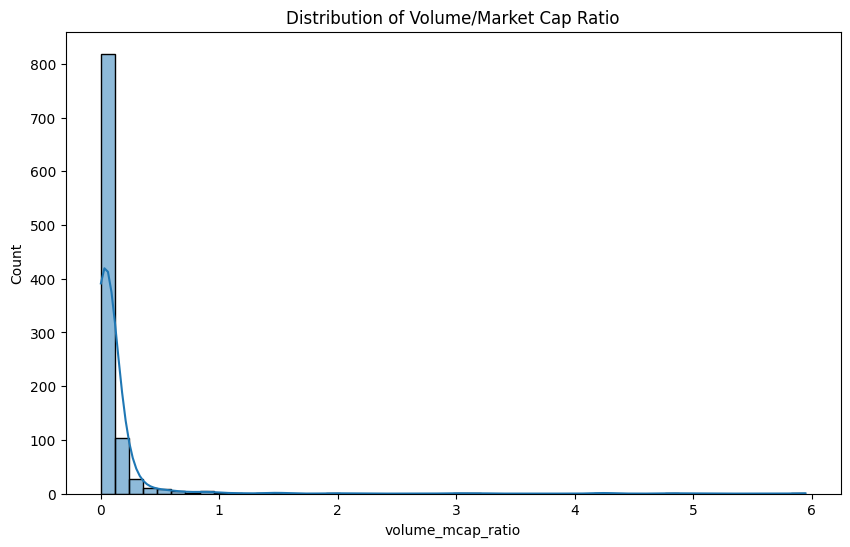

In [9]:
#Visualizations of Distribution of volume_mcap_ratio (liquidity indicator)

#Top coins by market cap and 24h volume
#Volatility trends using: abs_24h_change and abs_7d_change

#Correlation heatmap between features
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(df['volume_mcap_ratio'], bins=50, kde=True)
plt.title("Distribution of Volume/Market Cap Ratio")
plt.show()

**Feature Engineering**

Goal: Create new features to better predict liquidity.

| Feature Name           | Why It's Useful                                     |
| ---------------------- | --------------------------------------------------- |
| `log_mkt_cap`          | Stabilizes large differences in market caps         |
| `volatility_score`     | Captures price fluctuation using 24h and 7d changes |
| `volume_growth_rate`   | Tracks sudden spikes in trading activity            |
| `liquidity_risk_score` | Composite score combining volatility & volume       |


In [10]:
import numpy as np

df['log_mkt_cap'] = np.log(df['mkt_cap'] + 1)
df['volatility_score'] = df['abs_24h_change'] * 0.6 + df['abs_7d_change'] * 0.4
df['volume_growth_rate'] = df['24h_volume'].pct_change().fillna(0)

In [11]:
#Define Target Variable using Binary variable
threshold = df['volume_mcap_ratio'].median()
df['high_liquidity'] = (df['volume_mcap_ratio'] > threshold).astype(int)

In [12]:
#Split the Dataset for modeling
from sklearn.model_selection import train_test_split

X = df.drop(columns=['coin', 'symbol', 'date', 'high_liquidity'])
y = df['high_liquidity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

**3. Build Machine Learning Models**

Start with baseline models:

Logistic Regression (classification)

Random Forest

Gradient Boosting (XGBoost/LightGBM)

SVM (optional for small datasets)

In [14]:
import numpy as np

# Check for NaNs
print("Missing values per column:")
print(X_train.isna().sum())

# Check for infinite values
print("\nInfinite values per column:")
print(np.isinf(X_train).sum())

# Check for very large values
print("\nMax values per column:")
print(X_train.max())

Missing values per column:
price                 0
1h                    0
24h                   0
7d                    0
24h_volume            0
mkt_cap               0
volume_mcap_ratio     0
abs_1h_change         0
abs_24h_change        0
abs_7d_change         0
liquidity_label       0
log_mkt_cap           0
volatility_score      0
volume_growth_rate    0
dtype: int64

Infinite values per column:
price                 0
1h                    0
24h                   0
7d                    0
24h_volume            0
mkt_cap               0
volume_mcap_ratio     0
abs_1h_change         0
abs_24h_change        0
abs_7d_change         0
liquidity_label       0
log_mkt_cap           0
volatility_score      0
volume_growth_rate    1
dtype: int64

Max values per column:
price                 4.121727e+04
1h                    8.600000e-02
24h                   5.020000e-01
7d                    4.608000e+00
24h_volume            5.793497e+10
mkt_cap               7.760774e+11
volume_mcap_

In [15]:
# Replace infinity with NaN first
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Fill NaNs with column median
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_test.median())

In [16]:
#If some values are too large, normalize them
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [17]:
#Training Model again
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00        99

    accuracy                           1.00       199
   macro avg       1.00      1.00      1.00       199
weighted avg       1.00      1.00      1.00       199



**4. Evaluate Model Performance**
Metrics to use:

Classification:

Accuracy

Precision, Recall, F1-score

ROC-AUC curve

Regression:

R²

Mean Absolute Error (MAE)

Mean Squared Error (MSE)

Visualization:

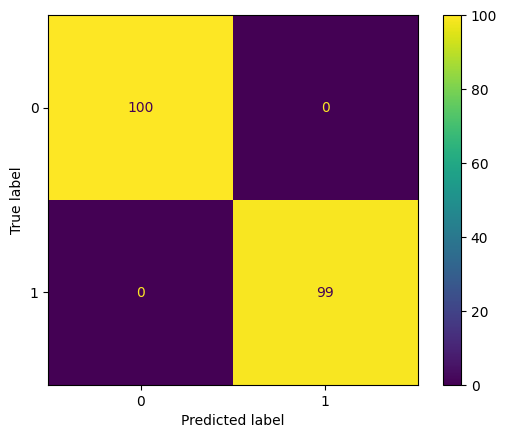

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

**5. Optimize Model**

Hyperparameter tuning using GridSearchCV or RandomizedSearchCV.

Feature selection to remove redundant predictors.

**6. Final Export of Model & Results**
Save your trained model for reuse:

In [22]:
import joblib

joblib.dump(model, "crypto_liquidity_model.pkl")

['crypto_liquidity_model.pkl']

In [24]:
#rebuild a DataFrame with the original column names before adding predictions
# Get original feature names BEFORE scaling
feature_names = X.columns

# Convert back to DataFrame
X_test_df = pd.DataFrame(X_test, columns=feature_names)

In [25]:
# Ensure y_test is aligned properly
results = X_test_df.copy()
results['Actual'] = y_test.values  # Convert y_test Series to NumPy if needed
results['Predicted'] = y_pred

# Save to CSV
results.to_csv("crypto_liquidity_predictions.csv", index=False)
print("Predictions exported to crypto_liquidity_predictions.csv")


Predictions exported to crypto_liquidity_predictions.csv


In [26]:
# 1. Convert X_test back to a DataFrame
feature_names = X.columns
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# 2. Merge predictions with actual values
results = X_test_df.copy()
results['Actual'] = y_test.values
results['Predicted'] = y_pred

# 3. Export results
results.to_csv("crypto_liquidity_predictions.csv", index=False)

print("Predictions successfully saved to crypto_liquidity_predictions.csv")
print(results.head())

Predictions successfully saved to crypto_liquidity_predictions.csv
      price        1h       24h        7d  24h_volume   mkt_cap  \
0 -0.141872  2.943371  3.054063  1.002962   -0.092697 -0.095559   
1 -0.141696 -0.263150 -0.354063 -0.049278   -0.095604 -0.081677   
2 -0.141920  0.564339 -0.032878 -0.266049   -0.093937 -0.085228   
3  0.183527  0.081637  0.431055 -0.356370   -0.097249 -0.096374   
4 -0.141463  0.564339 -0.835840  0.181040   -0.084088 -0.091863   

   volume_mcap_ratio  abs_1h_change  abs_24h_change  abs_7d_change  \
0           0.061212       2.966556        3.195376       0.780523   
1          -0.302649      -0.403025       -0.618654      -0.343007   
2          -0.251732       0.466545       -0.259216      -0.198346   
3          -0.294941      -0.040704        0.259971      -0.101906   
4           0.258559       0.466545       -0.199310      -0.097084   

   liquidity_label  log_mkt_cap  volatility_score  volume_growth_rate  Actual  \
0        -0.318195    -0.631

In [27]:
import os
print(os.listdir())  # Should include crypto_liquidity_predictions.csv

['.config', 'coin_gecko_2022-03-16.csv', 'crypto_liquidity_model.pkl', 'crypto_liquidity_predictions.csv', 'crypto_liquidity_cleaned.csv', 'coin_gecko_2022-03-17.csv', 'sample_data']


In [28]:
from google.colab import files
files.download("crypto_liquidity_predictions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
import pandas as pd

# Recreate DataFrame from NumPy array
feature_names = X.columns  # Original feature names before scaling
X_test_df = pd.DataFrame(X_test, columns=feature_names)


In [32]:
# Create results DataFrame
results = X_test_df.copy()

# Add actual target and predicted target
results['Actual'] = y_test.values  # Ensure y_test is aligned properly
results['Predicted'] = y_pred

# Preview
print(results.head())

      price        1h       24h        7d  24h_volume   mkt_cap  \
0 -0.141872  2.943371  3.054063  1.002962   -0.092697 -0.095559   
1 -0.141696 -0.263150 -0.354063 -0.049278   -0.095604 -0.081677   
2 -0.141920  0.564339 -0.032878 -0.266049   -0.093937 -0.085228   
3  0.183527  0.081637  0.431055 -0.356370   -0.097249 -0.096374   
4 -0.141463  0.564339 -0.835840  0.181040   -0.084088 -0.091863   

   volume_mcap_ratio  abs_1h_change  abs_24h_change  abs_7d_change  \
0           0.061212       2.966556        3.195376       0.780523   
1          -0.302649      -0.403025       -0.618654      -0.343007   
2          -0.251732       0.466545       -0.259216      -0.198346   
3          -0.294941      -0.040704        0.259971      -0.101906   
4           0.258559       0.466545       -0.199310      -0.097084   

   liquidity_label  log_mkt_cap  volatility_score  volume_growth_rate  Actual  \
0        -0.318195    -0.631605          1.605235           -0.049557       1   
1        -0.31

In [35]:
#Export predictions for reporting

# 1. Convert X_test (NumPy array) back to DataFrame
feature_names = X.columns
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# 2. Add Actual and Predicted columns
results = X_test_df.copy()
results['Actual'] = y_test.values
results['Predicted'] = y_pred

# 3. Save to CSV
results.to_csv("crypto_liquidity_predictions.csv", index=False)
print("Predictions successfully saved!")

# 4. Preview
print(results.head())

Predictions successfully saved!
      price        1h       24h        7d  24h_volume   mkt_cap  \
0 -0.141872  2.943371  3.054063  1.002962   -0.092697 -0.095559   
1 -0.141696 -0.263150 -0.354063 -0.049278   -0.095604 -0.081677   
2 -0.141920  0.564339 -0.032878 -0.266049   -0.093937 -0.085228   
3  0.183527  0.081637  0.431055 -0.356370   -0.097249 -0.096374   
4 -0.141463  0.564339 -0.835840  0.181040   -0.084088 -0.091863   

   volume_mcap_ratio  abs_1h_change  abs_24h_change  abs_7d_change  \
0           0.061212       2.966556        3.195376       0.780523   
1          -0.302649      -0.403025       -0.618654      -0.343007   
2          -0.251732       0.466545       -0.259216      -0.198346   
3          -0.294941      -0.040704        0.259971      -0.101906   
4           0.258559       0.466545       -0.199310      -0.097084   

   liquidity_label  log_mkt_cap  volatility_score  volume_growth_rate  Actual  \
0        -0.318195    -0.631605          1.605235           -0.

In [36]:
#Cross Validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())


Cross-validation scores: [nan nan nan nan nan]
Mean accuracy: nan


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_response.py", line 214, in _get_response_values
    y_pred = prediction_method(X)
             ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py", line 904, in predict


**7. Hyperparameter Tuning**
Use GridSearchCV to find optimal Random Forest parameters

In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}


#Deliverables 2
EDA Report

In [39]:
print(df.describe())

              price          1h         24h          7d    24h_volume  \
count  9.930000e+02  993.000000  993.000000  993.000000  9.930000e+02   
mean   6.194355e+02    0.009723    0.023737    0.023535  2.893109e+08   
std    4.419811e+03    0.026934    0.059303    0.229667  2.769908e+09   
min    1.484000e-09   -0.704000   -0.646000   -0.558000  0.000000e+00   
25%    1.944270e-01    0.001000    0.001000   -0.041000  1.766976e+06   
50%    1.100000e+00    0.006000    0.016000    0.000000  8.343005e+06   
75%    7.150000e+00    0.019000    0.035000    0.037000  4.003652e+07   
max    4.121727e+04    0.095000    0.577000    4.608000  5.793497e+10   

            mkt_cap  volume_mcap_ratio  abs_1h_change  abs_24h_change  \
count  9.930000e+02         993.000000     993.000000      993.000000   
mean   3.780941e+09           0.103743       0.013048        0.034553   
std    3.817057e+10           0.366932       0.025488        0.053719   
min    6.577043e+07           0.000000       0.000

<Axes: xlabel='symbol'>

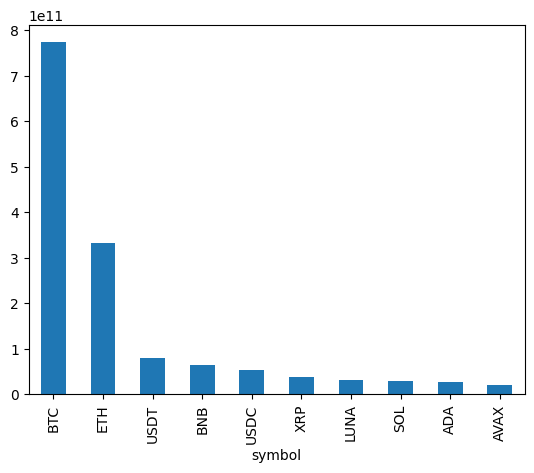

In [40]:
df.groupby('symbol')['mkt_cap'].mean().sort_values(ascending=False).head(10).plot(kind='bar')


<Axes: xlabel='volume_mcap_ratio', ylabel='Count'>

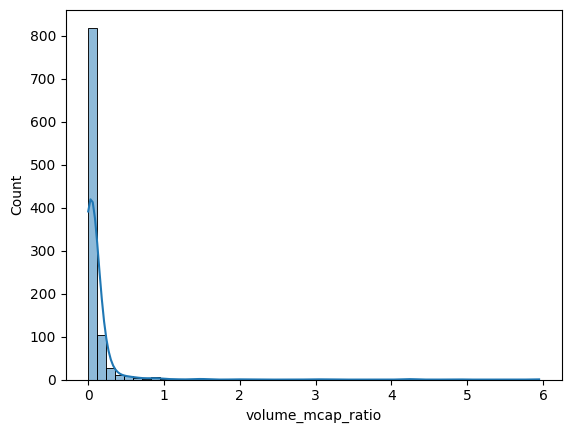

In [41]:
sns.histplot(df['volume_mcap_ratio'], bins=50, kde=True)

#Deliverables 3
HLD & LLD Document

1. High-Level Design (HLD) in pdf attached

Project Overview

Problem Statement

Scope

System Architecture Diagram

Module Descriptions

Technologies Used

Data Flow Overview

2. Low-Level Design (LLD)

The LLD will include:

Detailed component breakdown:

Preprocessing steps

Feature engineering logic

Model building & evaluation

Deployment flow

Algorithms and data transformations

Database / file handling structure

Error handling & edge cases

Final pipeline explanation

#Deliverables 4
Pipeline Architecture and Document

Data Source (CoinGecko CSV)

    ↓
Data Cleaning & Preprocessing

    ↓
Feature Engineering

    ↓
Model Training

    ↓
Evaluation

    ↓
Deployment

crypto_liquidity_project/
│
├── data/
│   ├── coin_gecko_2022-03-16.csv
│   ├── coin_gecko_2022-03-17.csv
│   └── crypto_liquidity_cleaned.csv
│
├── notebooks/
│   ├── EDA.ipynb
│   └── Modeling.ipynb
│
├── reports/
│   ├── EDA_Report.pdf
│   ├── HLD.pdf
│   ├── LLD.pdf
│   ├── Pipeline_Architecture.png
│   └── Final_Report.pdf
│
├── model/
│   └── crypto_liquidity_model.pkl
│
├── app/
│   └── app.py
│
└── README.md